# Resume Parsing
Version 3.0

# Imports

In [ ]:
!pip install PyMuPDF
!pip install docx2pdf
import pandas as pd
import numpy as np
import sys
import fitz
from docx2pdf import convert
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.8 MB 4.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Kaggle API

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

KeyboardInterrupt: ignored

In [ ]:
!kaggle datasets download -d snehaanbhawal/resume-dataset

In [ ]:
!unzip resume-dataset.zip

# Pre-processing
* It consists of some main steps
    * Lowercase
    * Removing Punctuation
    * Tokenization
    * Stopword Filtering
    * Stemming
    * Lemmatization

## Cleaning

In [ ]:
def clean(df):
  resume_df = df.copy()
  resume_df[['ID']] = resume_df[['ID']].apply(pd.to_numeric, errors='coerce')
  resume_df.drop(columns=['Resume_html'], inplace = True)
  return resume_df

## Lowercase

In [ ]:
def to_lower(df):
  lower_df = df.copy()
  lower_df["Resume_str"] = lower_df["Resume_str"].str.lower()
  lower_df["Category"] = lower_df["Category"].str.lower()
  return lower_df

## Removing Punctuation

In [ ]:
def rem_punct(df):
  punct_df = df.copy()
  punct_df['punct_sent'] = punct_df.apply(lambda row: "".join([char for char in row['Resume_str'] if char not in string.punctuation]), axis=1)
  return punct_df

## Tokenization

In [ ]:
def to_tokens(df):
  tokens_df = df.copy()
  tokens_df['tokenized_sents'] = tokens_df.apply(lambda row: nltk.word_tokenize(row['punct_sent']), axis=1)
  return tokens_df

## Stop Words

In [ ]:
def rem_stop_words(df):
  stop_df = df.copy()
  stop_words = stopwords.words('english')
  stop_df['stop_words'] = stop_df.apply(lambda row: [word for word in row['tokenized_sents'] if word not in stop_words], axis=1)
  return stop_df

## Stemming

In [ ]:
def stemming(df):
  new_df = df.copy()
  porter = PorterStemmer()
  new_df['Stemmed'] = df.apply(lambda row:[porter.stem(word) for word in row['stop_words']], axis = 1)
  return new_df

## Lemmatization

In [ ]:
def lemmatizing(df):
  new_df = df.copy()
  lemmatizer = WordNetLemmatizer()
  new_df['lemmatized'] = df.apply(lambda row:[lemmatizer.lemmatize(word) for word in row['stop_words']], axis = 1)
  return new_df

# Feature Extraction

## TF

In [ ]:
def TF_doc(df):
  TF_document_df = df.copy()
  #### Retrun to stemming / lemmetization
  TF_document_df['TF_doc'] = TF_document_df.apply(lambda row: Counter(row['stop_words']), axis=1)
  return TF_document_df

## TF for each Category

In [ ]:
def TF_category(df):
  ## Getting the Categories Names
  TF_cat = pd.DataFrame(
                  columns=pd.Index( df.Category.unique()),
                  index=pd.Index([]))
  ## Calculating words frequency within each category
  for index, row in df.iterrows():
    for item, value in row["TF_doc"].items():
      if item not in TF_cat.index:
        TF_cat.loc[item] = 0
        TF_cat.loc[item, row["Category"]] = value
      else:      
        TF_cat.loc[item, row["Category"]] += value

  return TF_cat

In [ ]:
def TF_Normalize(df):
  TF_Normalized = df.copy()
  for col in TF_Normalized:
    TF_Normalized[col]/=TF_Normalized[col].sum()
  return TF_Normalized

## IDF

In [ ]:
def IDF(df):
  # Make a Copy to work with
  IDF_DF = df.copy()
  
  # 1+ loge(No of documents in corpus/No. of documents containing the word)
  IDF_DF['IDF'] = IDF_DF.apply(lambda row: 1+ np.log(len(IDF_DF.columns)/row.astype(bool).sum()), axis=1)

  return IDF_DF

## TF-IDF

In [ ]:
def TF_IDF(TF, IDF):
  TF_IDF_DF = TF.copy()
  TF_IDF_DF = TF_IDF_DF.multiply(IDF["IDF"], axis="index")
  return TF_IDF_DF

# Main

In [ ]:
def main(file_name):
  resume_df = pd.read_csv(file_name)
  cleaned_df = clean(resume_df)
  lowered_df = to_lower(cleaned_df)
  punct_df = rem_punct(lowered_df)
  tokenized_df = to_tokens(punct_df)
  stop_words_df = rem_stop_words(tokenized_df)
  stemmed_df = stemming(stop_words_df)
  lemma_df = lemmatizing(stemmed_df)
  
  final_df = lemma_df

  return final_df

In [ ]:
train_result = main("Resume/Resume.csv")

In [ ]:
train_result

,ID,Resume_str,Category,punct_sent,tokenized_sents,stop_words,Stemmed,lemmatized
0,16852973,hr administrator/marketing associate\...,hr,hr administratormarketing associate\n...,"[hr, administratormarketing, associate, hr, ad...","[hr, administratormarketing, associate, hr, ad...","[hr, administratormarket, associ, hr, administ...","[hr, administratormarketing, associate, hr, ad..."
1,22323967,"hr specialist, us hr operations ...",hr,hr specialist us hr operations ...,"[hr, specialist, us, hr, operations, summary, ...","[hr, specialist, us, hr, operations, summary, ...","[hr, specialist, us, hr, oper, summari, versat...","[hr, specialist, u, hr, operation, summary, ve..."
2,33176873,hr director summary over 2...,hr,hr director summary over 2...,"[hr, director, summary, over, 20, years, exper...","[hr, director, summary, 20, years, experience,...","[hr, director, summari, 20, year, experi, recr...","[hr, director, summary, 20, year, experience, ..."
3,27018550,hr specialist summary dedica...,hr,hr specialist summary dedica...,"[hr, specialist, summary, dedicated, driven, a...","[hr, specialist, summary, dedicated, driven, d...","[hr, specialist, summari, dedic, driven, dynam...","[hr, specialist, summary, dedicated, driven, d..."
4,17812897,hr manager skill highlights ...,hr,hr manager skill highlights ...,"[hr, manager, skill, highlights, hr, skills, h...","[hr, manager, skill, highlights, hr, skills, h...","[hr, manag, skill, highlight, hr, skill, hr, d...","[hr, manager, skill, highlight, hr, skill, hr,..."
...,...,...,...,...,...,...,...,...
2479,99416532,rank: sgt/e-5 non- commissioned offic...,aviation,rank sgte5 non commissioned officer i...,"[rank, sgte5, non, commissioned, officer, in, ...","[rank, sgte5, non, commissioned, officer, char...","[rank, sgte5, non, commiss, offic, charg, brig...","[rank, sgte5, non, commissioned, officer, char..."
2480,24589765,"government relations, communications ...",aviation,government relations communications a...,"[government, relations, communications, and, o...","[government, relations, communications, organi...","[govern, relat, commun, organiz, develop, dire...","[government, relation, communication, organiza..."
2481,31605080,geek squad agent professional...,aviation,geek squad agent professional...,"[geek, squad, agent, professional, profile, it...","[geek, squad, agent, professional, profile, su...","[geek, squad, agent, profession, profil, suppo...","[geek, squad, agent, professional, profile, su..."
2482,21190805,program director / office manager ...,aviation,program director office manager ...,"[program, director, office, manager, summary, ...","[program, director, office, manager, summary, ...","[program, director, offic, manag, summari, hig...","[program, director, office, manager, summary, ..."


# Visualizations

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
from wordcloud import WordCloud

## Number Of resumes per each category

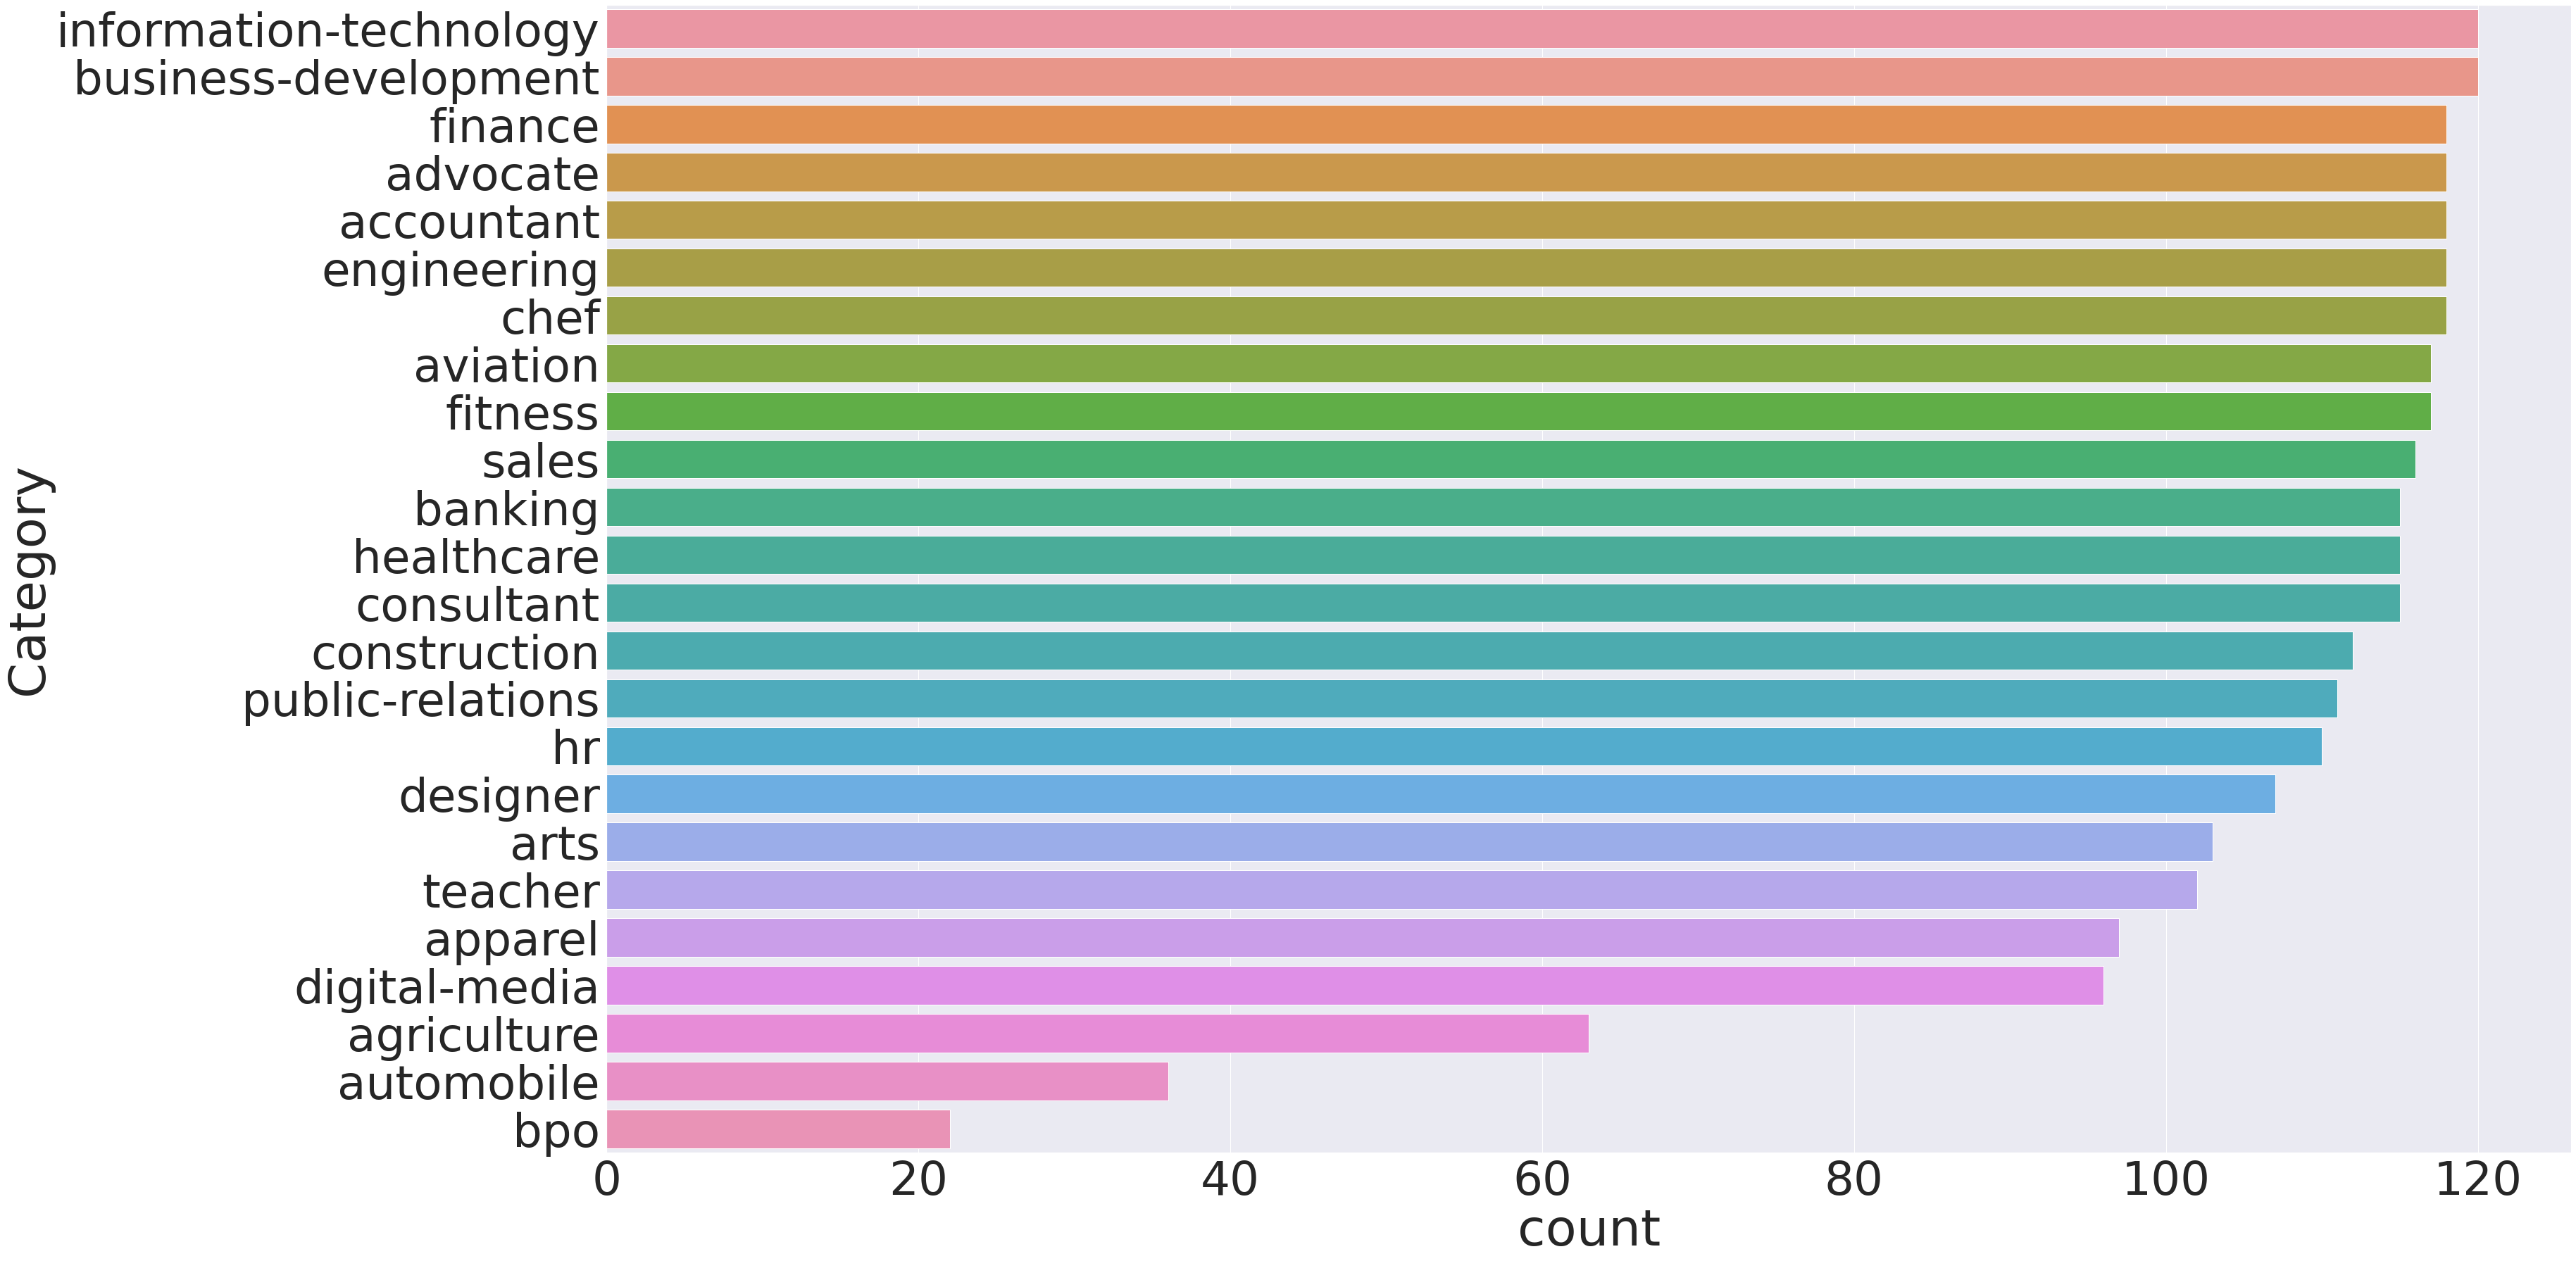

In [ ]:
plt.figure(figsize=(50,30))
sns.set(font_scale = 6)
ax = sns.countplot(y=train_result["Category"],  data=train_result, order = train_result["Category"].value_counts().index )
for p, label in zip(ax.patches, train_result["Category"].value_counts()):   
    pass
    # ax.annotate(label, (p.get_x()+0.25, p.get_height()+0.5))

## Word Cloud

In [ ]:
def joining_fn(text):
  return ' '.join(text)

In [ ]:
train_result['stop_words'].apply(joining_fn)

0       hr administratormarketing associate hr adminis...
1       hr specialist us hr operations summary versati...
2       hr director summary 20 years experience recrui...
3       hr specialist summary dedicated driven dynamic...
4       hr manager skill highlights hr skills hr depar...
                              ...                        
2479    rank sgte5 non commissioned officer charge bri...
2480    government relations communications organizati...
2481    geek squad agent professional profile support ...
2482    program director office manager summary highly...
2483    storekeeper ii professional summary purpose do...
Name: stop_words, Length: 2484, dtype: object

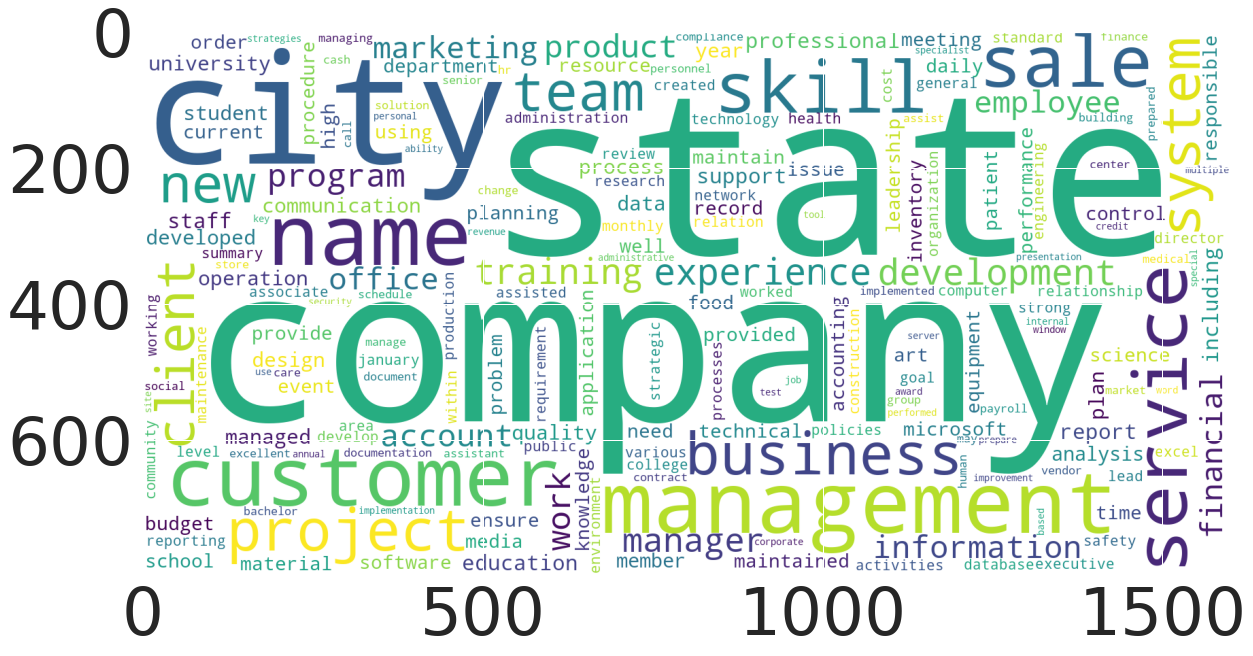

In [ ]:
wordcloud = WordCloud(background_color="white",width=1600, height=800, collocations=False).generate(' '.join(train_result['tokenized_sents'].apply(joining_fn)))
plt.figure( figsize=(20,10), facecolor='w')
plt.imshow(wordcloud)

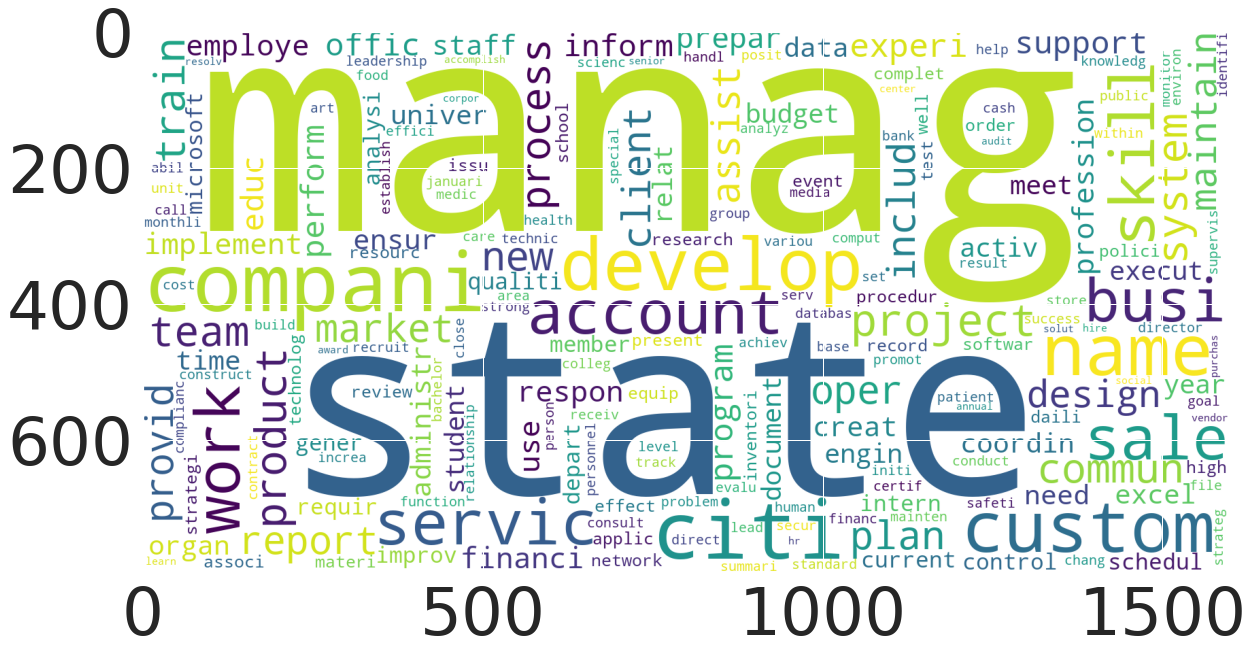

In [ ]:
wordcloud = WordCloud(background_color="white",width=1600, height=800, collocations=False).generate(' '.join(train_result['Stemmed'].apply(joining_fn)))
plt.figure( figsize=(20,10), facecolor='w')
plt.imshow(wordcloud)

## Resume Length

*Univariate visualization*
---
Single-variable or univariate visualization is the simplest type of visualization which consists of observations on only a single characteristic or attribute. Univariate visualization includes histogram, bar plots and line charts.

In [ ]:
train_result['resume_len'] = train_result['Resume_str'].astype(str).apply(len)

In [ ]:
train_result['words_count'] = train_result['Stemmed'].apply(len)

In [ ]:
train_result

,ID,Resume_str,Category,punct_sent,tokenized_sents,stop_words,Stemmed,lemmatized,resume_len,words_count
0,16852973,hr administrator/marketing associate\...,hr,hr administratormarketing associate\n...,"[hr, administratormarketing, associate, hr, ad...","[hr, administratormarketing, associate, hr, ad...","[hr, administratormarket, associ, hr, administ...","[hr, administratormarketing, associate, hr, ad...",5442,520
1,22323967,"hr specialist, us hr operations ...",hr,hr specialist us hr operations ...,"[hr, specialist, us, hr, operations, summary, ...","[hr, specialist, us, hr, operations, summary, ...","[hr, specialist, us, hr, oper, summari, versat...","[hr, specialist, u, hr, operation, summary, ve...",5572,548
2,33176873,hr director summary over 2...,hr,hr director summary over 2...,"[hr, director, summary, over, 20, years, exper...","[hr, director, summary, 20, years, experience,...","[hr, director, summari, 20, year, experi, recr...","[hr, director, summary, 20, year, experience, ...",7720,722
3,27018550,hr specialist summary dedica...,hr,hr specialist summary dedica...,"[hr, specialist, summary, dedicated, driven, a...","[hr, specialist, summary, dedicated, driven, d...","[hr, specialist, summari, dedic, driven, dynam...","[hr, specialist, summary, dedicated, driven, d...",2855,275
4,17812897,hr manager skill highlights ...,hr,hr manager skill highlights ...,"[hr, manager, skill, highlights, hr, skills, h...","[hr, manager, skill, highlights, hr, skills, h...","[hr, manag, skill, highlight, hr, skill, hr, d...","[hr, manager, skill, highlight, hr, skill, hr,...",9172,896
...,...,...,...,...,...,...,...,...,...,...
2479,99416532,rank: sgt/e-5 non- commissioned offic...,aviation,rank sgte5 non commissioned officer i...,"[rank, sgte5, non, commissioned, officer, in, ...","[rank, sgte5, non, commissioned, officer, char...","[rank, sgte5, non, commiss, offic, charg, brig...","[rank, sgte5, non, commissioned, officer, char...",5533,515
2480,24589765,"government relations, communications ...",aviation,government relations communications a...,"[government, relations, communications, and, o...","[government, relations, communications, organi...","[govern, relat, commun, organiz, develop, dire...","[government, relation, communication, organiza...",7108,681
2481,31605080,geek squad agent professional...,aviation,geek squad agent professional...,"[geek, squad, agent, professional, profile, it...","[geek, squad, agent, professional, profile, su...","[geek, squad, agent, profession, profil, suppo...","[geek, squad, agent, professional, profile, su...",2020,190
2482,21190805,program director / office manager ...,aviation,program director office manager ...,"[program, director, office, manager, summary, ...","[program, director, office, manager, summary, ...","[program, director, offic, manag, summari, hig...","[program, director, office, manager, summary, ...",5074,526


Average words count per category

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f83b2b14690>,
      dtype=object)

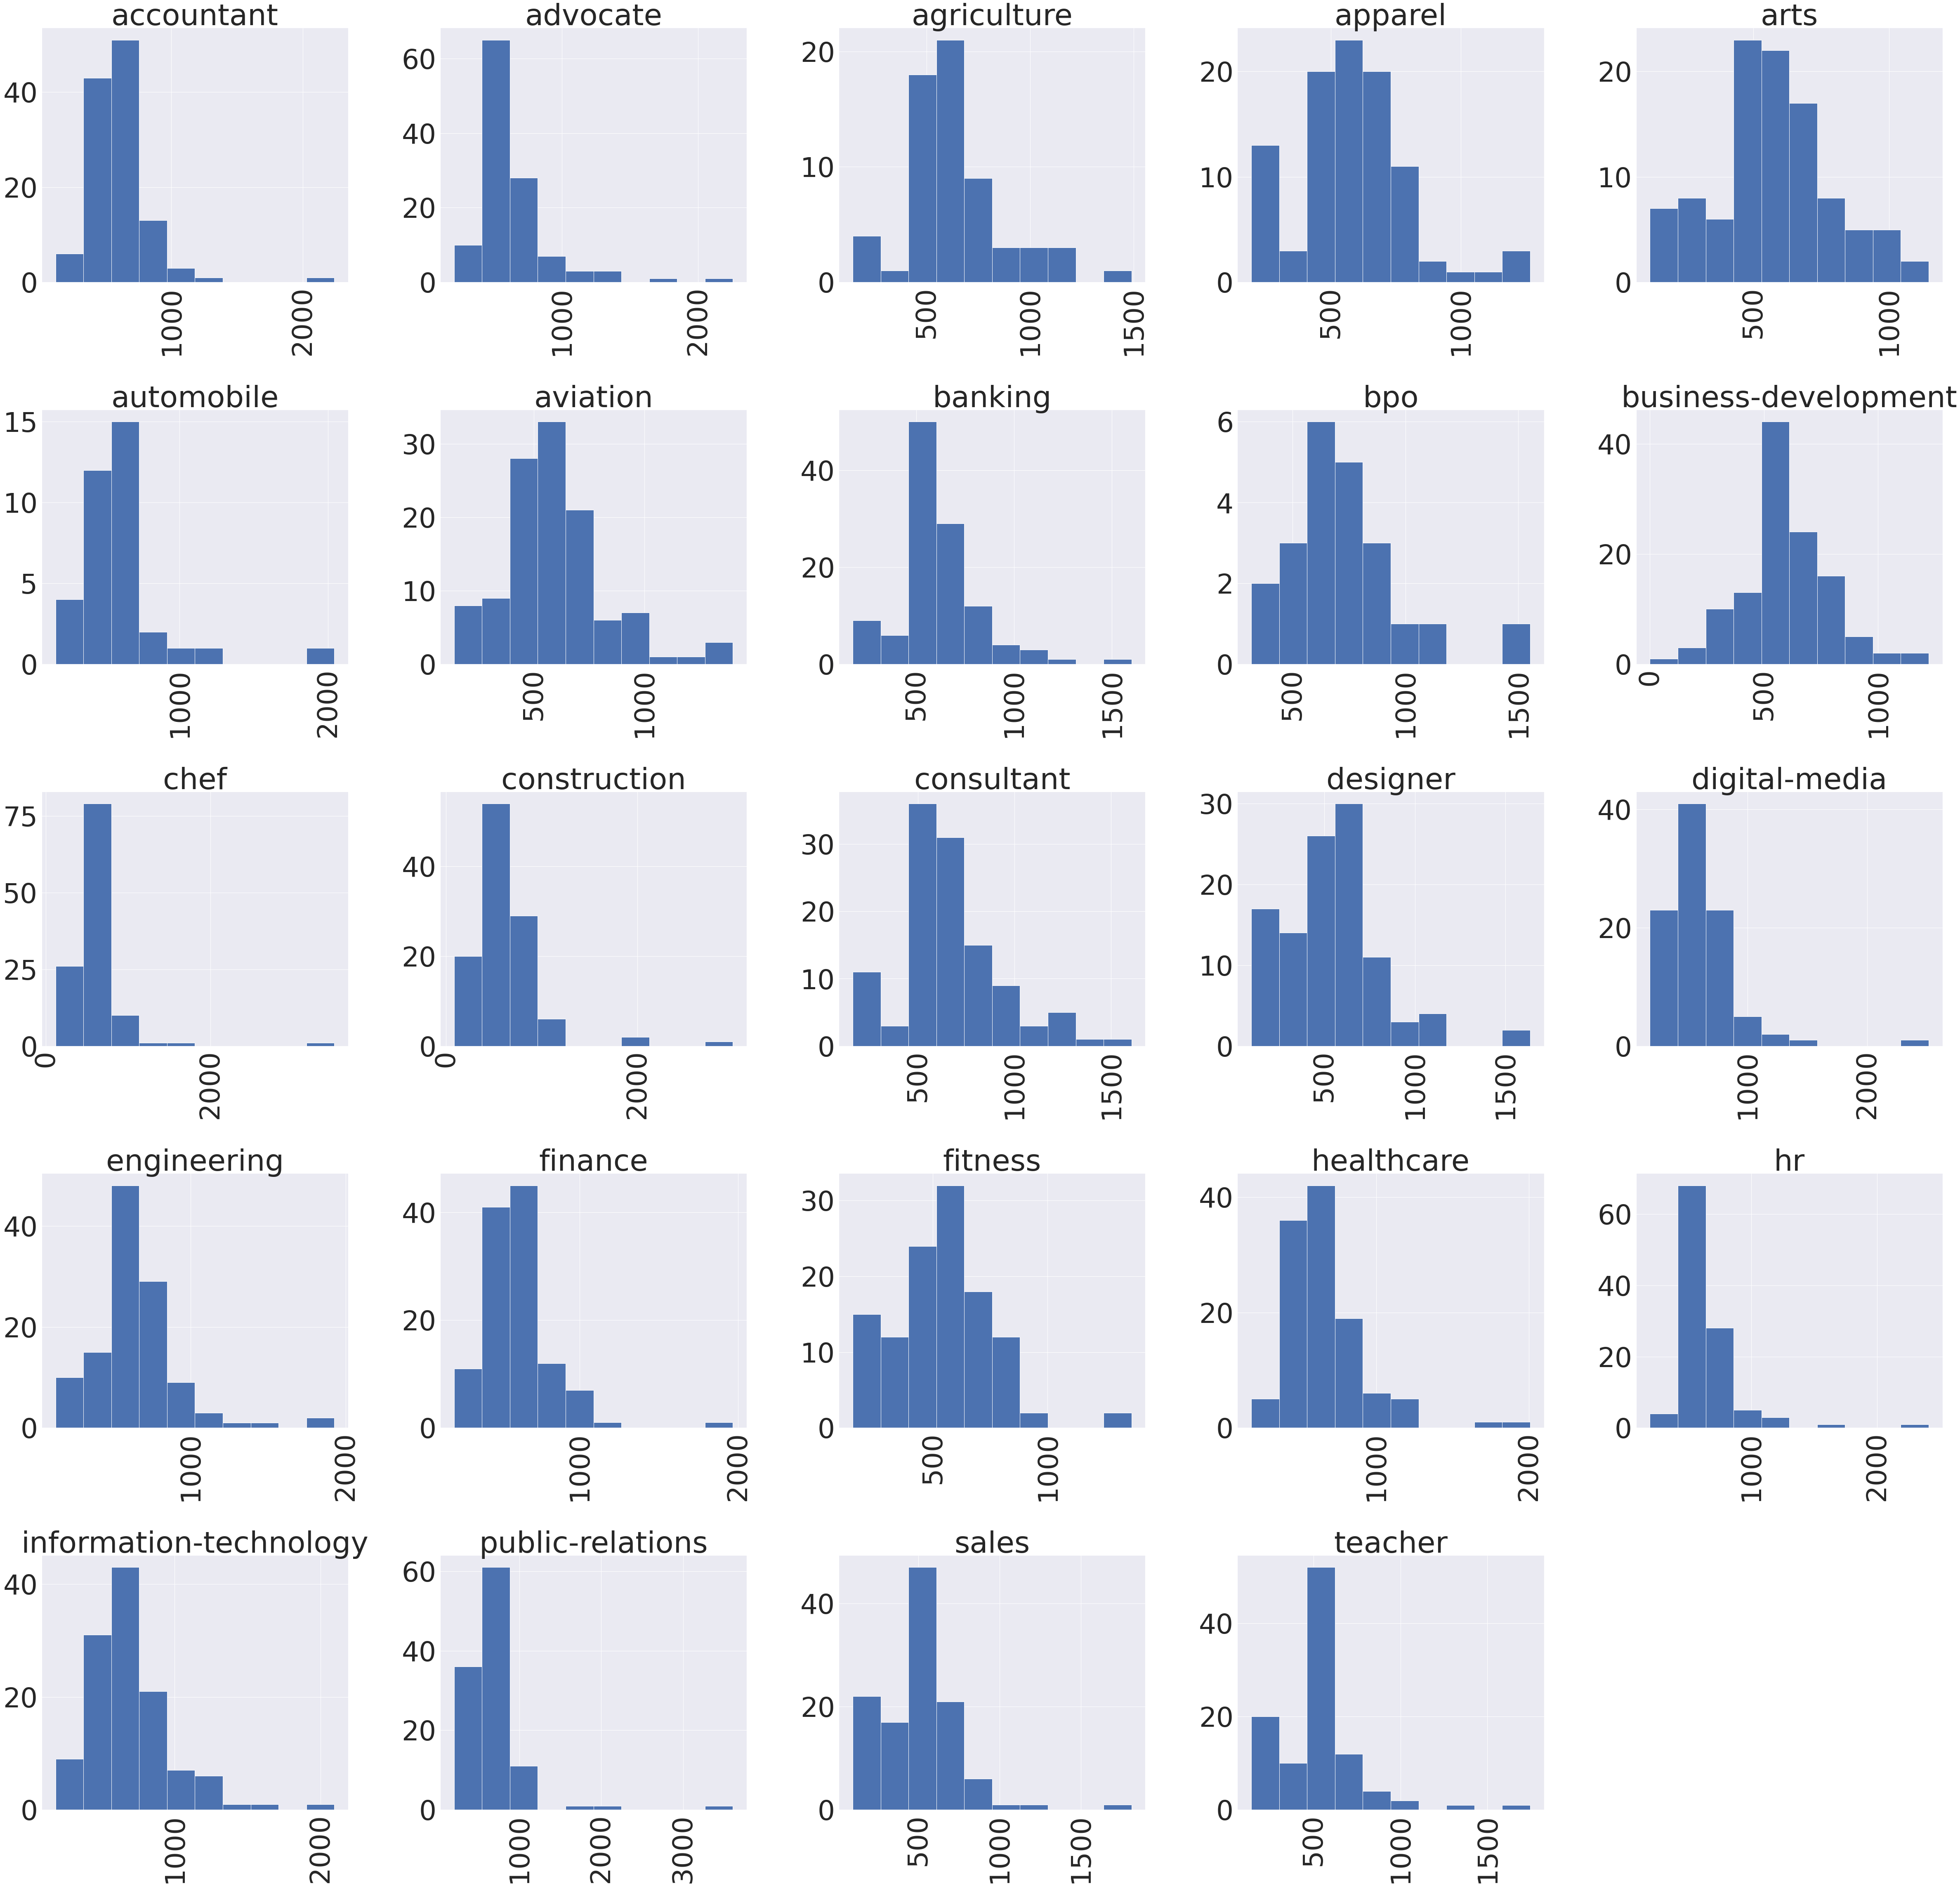

In [ ]:
train_result['words_count'].hist(by=train_result['Category'], figsize = (80, 80))

In [ ]:
train_result.to_csv("train_tf_idf.csv")

# Debugging

In [ ]:
resume_df = pd.read_csv("Resume/Resume.csv")
resume_df

In [ ]:
resume_df.describe()

In [ ]:
cleaned_df = clean(resume_df)
cleaned_df

In [ ]:
lowered_df = to_lower(cleaned_df)
lowered_df

In [ ]:
punct_df = rem_punct(lowered_df)
punct_df

In [ ]:
tokenized_df = to_tokens(punct_df)
tokenized_df

In [ ]:
stop_words_df = rem_stop_words(tokenized_df)
stop_words_df

In [ ]:
stemmed_df = stemming(stop_words_df)
stemmed_df

In [ ]:
lemma_df = lemmatizing(stemmed_df)
lemma_df

In [ ]:
TF_doc_df = TF_doc(stop_words_df)
TF_doc_df

In [ ]:
TF_cat_df = TF_category(TF_doc_df)
TF_cat_df

In [ ]:
TF_cat_df.to_csv("train.csv")

In [ ]:
TF_Norm_df = TF_Normalize(TF_cat_df)
TF_Norm_df

In [ ]:
IDF_df = IDF(TF_cat_df)
IDF_df

In [ ]:
TF_IDF_df = TF_IDF(TF_Norm_df, IDF_df)
TF_IDF_df

In [ ]:
TF_IDF_df.to_csv("TF_IDF.csv")

,hr,designer,information-technology,teacher,advocate,business-development,healthcare,fitness,agriculture,bpo,...,chef,finance,apparel,engineering,accountant,construction,public-relations,banking,arts,aviation
hr,0.011137,0.000039,0.000091,0.000042,0.000274,0.000175,0.000361,0.000289,0.000057,0.000906,...,0.000119,0.000181,0.000229,0.000113,0.000432,0.000075,0.000165,0.000287,0.000383,0.000066
administratormarketing,0.000091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
associate,0.000727,0.000649,0.000575,0.000573,0.000498,0.000449,0.000582,0.000663,0.000624,0.000906,...,0.000888,0.000405,0.001309,0.000319,0.000367,0.000395,0.000587,0.000552,0.000651,0.000483
administrator,0.00038,0.000039,0.00084,0.00007,0.000091,0.000131,0.000291,0.000084,0.000094,0.000095,...,0.000065,0.000149,0.000135,0.000154,0.00027,0.000075,0.000144,0.000132,0.000191,0.000165
summary,0.001019,0.001182,0.000685,0.001202,0.001006,0.000974,0.000863,0.001073,0.001001,0.00081,...,0.001018,0.001139,0.001012,0.000927,0.001243,0.001131,0.000938,0.001059,0.000957,0.001065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
productawareness,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000046
ciety,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000092
twinbrook,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000092
innocence,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000092
